
# 1 - Problem statement: SIGNS Dataset



One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the [SIGNS dataset](https://www.kaggle.com/datamunge/sign-language-mnist). The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1Qz_B0IjzLrp77cBWIz6DVTsG3l9PSFKr"></center>
<center><b>Figure 1</b>: SIGNS dataset <br></center>


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import time
import datetime
import pytz
from mlxtend.plotting import plot_decision_regions

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



Run the following code to load the dataset.

In [7]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


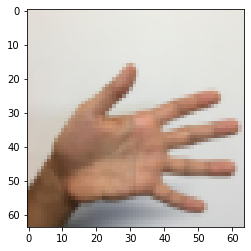

In [9]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [10]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)
# Normalize image vectors
train_x = X_train_flatten/255.
test_x = X_test_flatten/255.
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


<font color="red"><b>Note</b></font> that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

<mark>Your goal</mark> is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a tensorflow model that is almost the same as one you have previously built for cat recognition (but now using a softmax output).

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

## 1.1 - Callback and helper functions

In [11]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))
    print('Duration: {}s'.format(time.time() - self.begins))

In [12]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["categorical_accuracy","val_categorical_accuracy"]
  f, axs = plt.subplots(1,2,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')

  f.suptitle(titles, y=1.1)
  plt.tight_layout()
  plt.show()

## 1.2 - Baseline Model

In [13]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(25, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-09-22 19:55:50
Training: ends at 2020-09-22 19:58:23
Duration: 153.25543880462646s


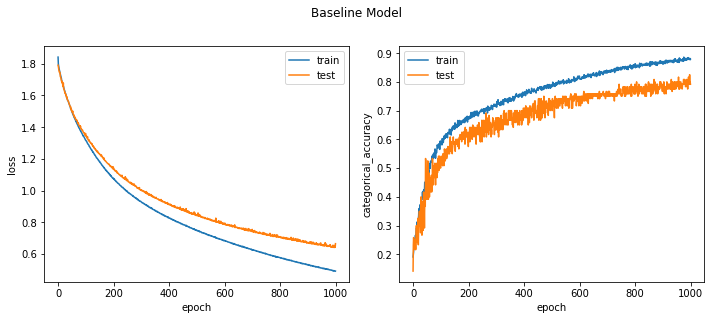

In [14]:
print_analysis("Baseline Model", history)

In [15]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 2ms/step - loss: 0.5001 - categorical_accuracy: 0.8824
Train loss: 0.500 - acc: 0.882
4/4 [==============================] - 0s 2ms/step - loss: 0.6657 - categorical_accuracy: 0.7917
Test loss: 0.666 - acc: 0.792


In [16]:
print("Number of parameters %.d" % model.count_params())

Number of parameters 307615


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                307225    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


## 1.3 - Batch Normalization

Training deep neural networks with tens of layers is challenging as they can be sensitive to the
initial random weights and configuration of the learning algorithm. One possible reason for
this dificulty is the distribution of the inputs to layers deep in the network may change after
each minibatch when the weights are updated. This can cause the learning algorithm to forever
chase a moving target. This change in the distribution of inputs to layers in the network is
referred to by the technical name **internal covariate shift**. <mark>Batch normalization</mark> is a technique for
training very deep neural networks that standardizes the inputs to a layer for each minibatch.
This has the effect of stabilizing the learning process and dramatically reducing the number of
training epochs required to train deep networks.

<mark>Batch normalization</mark> is a general technique that can be used to normalize the inputs to a layer. It can be used with most network types, such as Multilayer Perceptrons, Convolutional Neural Networks and Recurrent Neural Networks. Batch normalization **accelerates training**, in some cases by halving the number of epochs
(or better), and provides **some regularization effect**, **reducing generalization error**.


Batch normalization also sometimes reduces generalization error and allows dropout
to be omitted, due to the noise in the estimate of the statistics used to normalize each variable. **It may not be a good idea to use batch normalization and dropout in the same network**.

The **Batch Normalization** layer can be used to standardize inputs **before** or **after** the activation function of the previous layer. [The original paper](https://arxiv.org/abs/1502.03167) that introduced the method suggests adding batch normalization before the activation function of the previous layer. But, as usual in this course let try both of them.

### 1.3.1 - Batch Normalization After Activation Function

A new Batch Normalization layer can be added to the model after the hidden layer before the output layer.

In [18]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(25, activation=tf.nn.relu,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))


# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-09-22 19:59:26
Training: ends at 2020-09-22 20:02:07
Duration: 160.46213912963867s


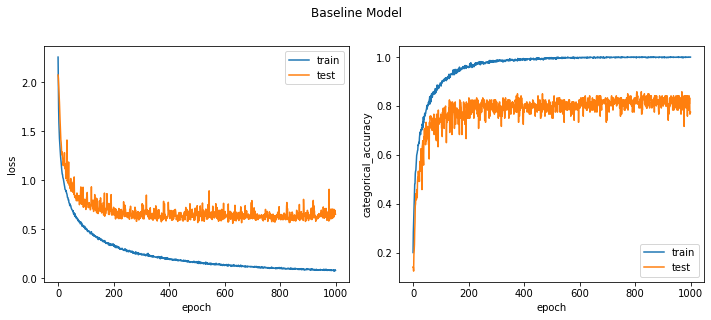

In [19]:
print_analysis("Baseline Model", history)

In [23]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 2ms/step - loss: 0.1437 - categorical_accuracy: 1.0000
Train loss: 0.144 - acc: 1.000
4/4 [==============================] - 0s 3ms/step - loss: 0.5037 - categorical_accuracy: 0.8917
Test loss: 0.504 - acc: 0.892


### 1.3.2 - Batch Normalization Before Activation Function (original paper)

In [21]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(25, kernel_initializer="he_uniform"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.nn.relu))

model.add(tf.keras.layers.Dense(12,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.nn.relu))

model.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=32,
                    epochs=1000,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2020-09-22 20:02:55
Training: ends at 2020-09-22 20:05:43
Duration: 167.8551926612854s


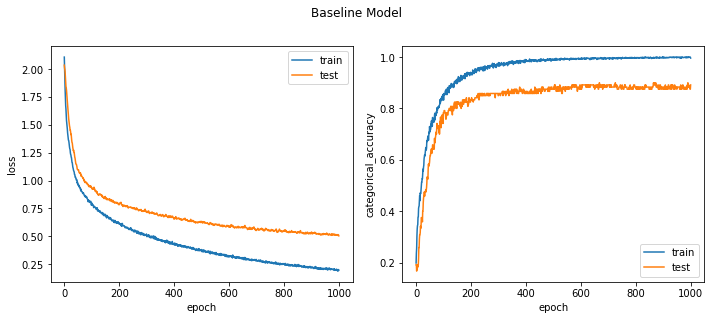

In [24]:
print_analysis("Baseline Model", history)

In [26]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 0s 2ms/step - loss: 0.1437 - categorical_accuracy: 1.0000
Train loss: 0.144 - acc: 1.000
4/4 [==============================] - 0s 2ms/step - loss: 0.5037 - categorical_accuracy: 0.8917
Test loss: 0.504 - acc: 0.892


### 1.3.3 - Test with your own image

You can now take a picture of your hand and see the output of your model.

float32
(1, 12288)


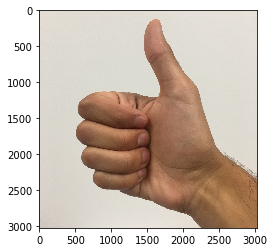

In [30]:
# example of converting an image with the Keras API
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.transform import resize

# load the image
img = load_img('thumbs_up.jpg')

# convert to numpy array
img_array = img_to_array(img)/255
img_array_res = resize(img_array, (64,64)).reshape((1, 64*64*3))

print(img_array_res.dtype)
print(img_array_res.shape)

plt.imshow(img_array)

In [31]:
model.predict(img_array_res).argmax()
#model.predict(test_x[:,0])

3

You indeed deserved a "thumbs-up" although as you can see the algorithm seems to classify it incorrectly. The reason is that the training set doesn't contain any "thumbs-up", so the model doesn't know how to deal with it! We call that a "mismatched data distribution" and it is one of the various of the next lectures.

### 1.3.4 Exercise





<mark>This exercise</mark> lists some ideas for extending the use of Batch Normalization that you may wish to explore.

1. **Without Beta and Gamma**. Update the example to not use the beta and gamma
parameters in the batch normalization layer and compare results.
  - hint: read the [documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/) to understand how to disable Beta and Gamma.
2. **Without Momentum**. Update the example to not use momentum in the batch normalization layer during training and compare results.
  - The statistics used to perform the standardization, e.g. the mean and standard deviation of each variable, are updated for each mini batch and a running average is maintained. A
momentum argument allows you to control how much of the statistics from the previous mini-batch to include when the update is calculated. By default, this is kept high with a value of 0.99. This can be set to 0.0 to only use statistics from the current minibatch, as described in the original paper.
  - BatchNormalization(momentum=0.0)

In [ ]:
# PUT YOUR CODE HERE